In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ANNOTATIONS_PATH = "/content/drive/My Drive/Car Licence Plate Detection Project/Car_Licence_Plate_Detection_Dataset/annotations"  # Update with your path
IMAGES_PATH = "/content/drive/My Drive/Car Licence Plate Detection Project/Car_Licence_Plate_Detection_Dataset/images"

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    filename = root.find("filename").text
    image_path = os.path.join(IMAGES_PATH, filename)

    size = root.find("size")
    orig_width = int(size.find("width").text)
    orig_height = int(size.find("height").text)

    bbox = root.find("object").find("bndbox")
    xmin = int(bbox.find("xmin").text)
    ymin = int(bbox.find("ymin").text)
    xmax = int(bbox.find("xmax").text)
    ymax = int(bbox.find("ymax").text)

    return image_path, (xmin, ymin, xmax, ymax), (orig_width, orig_height)

# Read all annotations
image_paths, bboxes, image_sizes = [], [], []
for xml_file in os.listdir(ANNOTATIONS_PATH):
    if xml_file.endswith(".xml"):
        img_path, bbox, img_size = parse_annotation(os.path.join(ANNOTATIONS_PATH, xml_file))
        image_paths.append(img_path)
        bboxes.append(bbox)
        image_sizes.append(img_size)

In [4]:
IMG_SIZE = 224  # Resize all images to 224x224

def preprocess_data(image_paths, bboxes, image_sizes, img_size=IMG_SIZE):
    X, y = [], []

    for i, img_path in enumerate(image_paths):
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (img_size, img_size))
        image = image / 255.0  # Normalize
        X.append(image)

        # Scale bounding box
        orig_w, orig_h = image_sizes[i]
        scale_x, scale_y = img_size / orig_w, img_size / orig_h

        xmin, ymin, xmax, ymax = bboxes[i]
        new_xmin = xmin * scale_x
        new_ymin = ymin * scale_y
        new_xmax = xmax * scale_x
        new_ymax = ymax * scale_y

        y.append([new_xmin, new_ymin, new_xmax, new_ymax])

    return np.array(X), np.array(y)

# Prepare dataset
X, y = preprocess_data(image_paths, bboxes, image_sizes)

# Split into training & testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)


You're currently using Mean Absolute Error (MAE) as the metric for your object detection model. While MAE is useful for regression tasks, it's not the most suitable metric for evaluating object detection accuracy.

Here's how you can add accuracy as a metric in your code and why you should use Intersection over Union (IoU) for object detection tasks.

Understanding IoU for Object Detection

Intersection over Union (IoU) is a common metric used in object detection to evaluate the accuracy of predicted bounding boxes. IoU calculates the overlap between the predicted bounding box and the ground truth bounding box. A higher IoU indicates a better prediction.

In [9]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D

def build_improved_model(input_shape=(IMG_SIZE, IMG_SIZE, 3)):
    base_model = VGG19(input_shape=input_shape, include_top=False, weights="imagenet")
    base_model.trainable = False  # Freeze pre-trained layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation="linear")(x)  # Bounding box (xmin, ymin, xmax, ymax)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Compile with Smooth L1 Loss
def smooth_l1_loss(y_true, y_pred):
    diff = tf.abs(y_true - y_pred)
    less_than_one = tf.cast(diff < 1.0, "float32")
    loss = less_than_one * (0.5 * diff ** 2) + (1 - less_than_one) * (diff - 0.5)
    return tf.reduce_mean(loss)
def iou(y_true, y_pred):
    # Extract coordinates
    xmin_true, ymin_true, xmax_true, ymax_true = y_true[:, 0], y_true[:, 1], y_true[:, 2], y_true[:, 3]
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], y_pred[:, 3]

    # Calculate intersection area
    xmin_intersect = tf.maximum(xmin_true, xmin_pred)
    ymin_intersect = tf.maximum(ymin_true, ymin_pred)
    xmax_intersect = tf.minimum(xmax_true, xmax_pred)
    ymax_intersect = tf.minimum(ymax_true, ymax_pred)
    intersection_area = tf.maximum(0.0, xmax_intersect - xmin_intersect + 1) * tf.maximum(0.0, ymax_intersect - ymin_intersect + 1)

    # Calculate union area
    true_area = (xmax_true - xmin_true + 1) * (ymax_true - ymin_true + 1)
    pred_area = (xmax_pred - xmin_pred + 1) * (ymax_pred - ymin_pred + 1)

    # Calculate IoU
    iou = intersection_area / (true_area + pred_area - intersection_area)

    return tf.reduce_mean(iou)  # Average IoU over the batch
model = build_improved_model()
model.compile(optimizer=Adam(learning_rate=0.0001), loss=smooth_l1_loss, metrics=["mae", iou])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [10]:
EPOCHS = 50
BATCH_SIZE = 16

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - iou: 0.0000e+00 - loss: 125.5691 - mae: 126.0689 - val_iou: 0.0000e+00 - val_loss: 122.3379 - val_mae: 122.8379
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - iou: 0.0000e+00 - loss: 123.9305 - mae: 124.4297 - val_iou: 0.0000e+00 - val_loss: 120.9701 - val_mae: 121.4701
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - iou: 0.0000e+00 - loss: 122.4119 - mae: 122.9115 - val_iou: 0.0000e+00 - val_loss: 119.4770 - val_mae: 119.9762
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - iou: 0.0000e+00 - loss: 123.1510 - mae: 123.6506 - val_iou: 0.0000e+00 - val_loss: 117.8745 - val_mae: 118.3744
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - iou: 0.0000e+00 - loss: 120.5584 - mae: 121.0583 - val_iou: 0.0000e+00 - val_loss: 116.1333 - val_mae: 116.6333
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - iou: 0.0000e+00 - loss: 118.9319 - mae: 119.4318 - val_iou: 0.0000e+00 - val_loss: 114.2431 - val_mae: 114.7424
Epoch 7/5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step


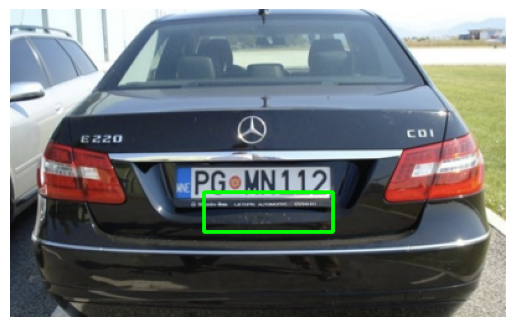

In [11]:
def predict_and_visualize(model, image_path):
    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

# Test on an image
test_image_path = image_paths[0]  # Pick an image
predict_and_visualize(model, test_image_path)

In [12]:
def predict_and_visualize_multiple(model, image_paths, num_images=15):
    for i in range(min(num_images, len(image_paths))):
        image_path = image_paths[i]
        image = cv2.imread(image_path)
        orig_h, orig_w = image.shape[:2]

        image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
        image_resized = np.expand_dims(image_resized, axis=0)

        pred_bbox = model.predict(image_resized)[0]

        # Scale bounding box back
        scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
        xmin, ymin, xmax, ymax = pred_bbox
        xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
        ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

        # Draw bounding box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image {i + 1}")  # Add title for each image
        plt.axis("off")
        plt.show()

# Predict and visualize for the first 15 images
predict_and_visualize_multiple(model, image_paths, num_images=15)

Output hidden; open in https://colab.research.google.com to view.

Saving ge4885330835677453198.jpg to ge4885330835677453198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


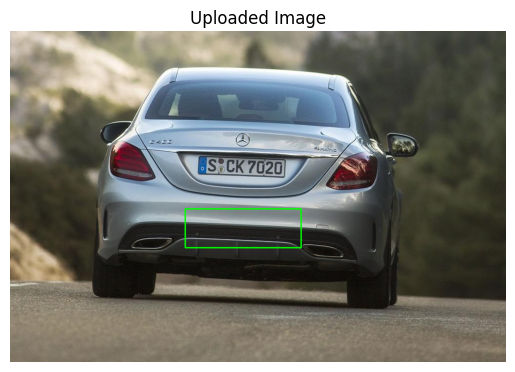

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def predict_and_visualize_uploaded(model):
    """Predicts the bounding box for an uploaded image and visualizes the result."""

    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn

    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Uploaded Image")  # Add title for each image
    plt.axis("off")
    plt.show()

# Example usage
predict_and_visualize_uploaded(model)

Saving istockphoto-502177448-612x612.jpg to istockphoto-502177448-612x612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


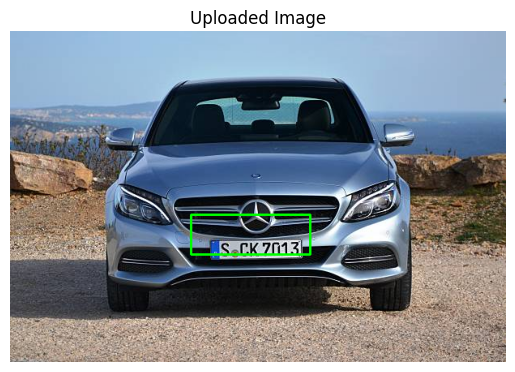

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def predict_and_visualize_uploaded(model):
    """Predicts the bounding box for an uploaded image and visualizes the result."""

    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn

    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Uploaded Image")  # Add title for each image
    plt.axis("off")
    plt.show()

# Example usage
predict_and_visualize_uploaded(model)

Saving istockphoto-1579917024-612x612.jpg to istockphoto-1579917024-612x612.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


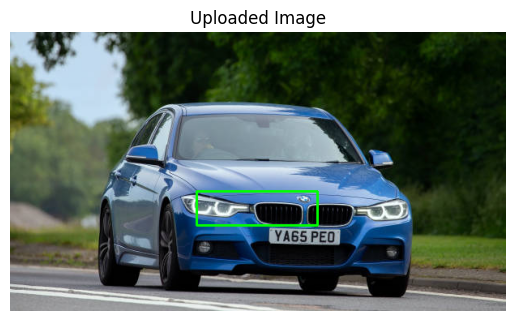

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def predict_and_visualize_uploaded(model):
    """Predicts the bounding box for an uploaded image and visualizes the result."""

    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn

    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Uploaded Image")  # Add title for each image
    plt.axis("off")
    plt.show()

# Example usage
predict_and_visualize_uploaded(model)

Saving stony-stratford-bucks-uk-feb-260nw-2260478283.webp to stony-stratford-bucks-uk-feb-260nw-2260478283.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


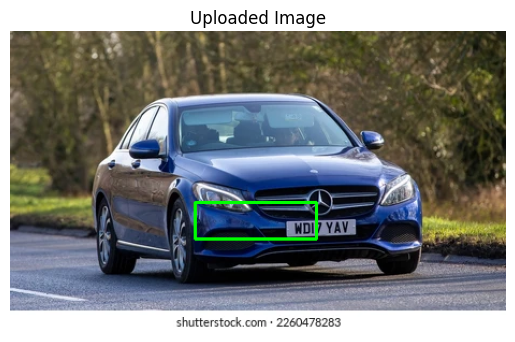

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

def predict_and_visualize_uploaded(model):
    """Predicts the bounding box for an uploaded image and visualizes the result."""

    uploaded = files.upload()
    for fn in uploaded.keys():
        image_path = fn

    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]

    image_resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0
    image_resized = np.expand_dims(image_resized, axis=0)

    pred_bbox = model.predict(image_resized)[0]

    # Scale bounding box back
    scale_x, scale_y = orig_w / IMG_SIZE, orig_h / IMG_SIZE
    xmin, ymin, xmax, ymax = pred_bbox
    xmin, xmax = int(xmin * scale_x), int(xmax * scale_x)
    ymin, ymax = int(ymin * scale_y), int(ymax * scale_y)

    # Draw bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Uploaded Image")  # Add title for each image
    plt.axis("off")
    plt.show()

# Example usage
predict_and_visualize_uploaded(model)